In [202]:
import os
import yaml
from glob import glob
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow import data as tf_data
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pprint import pprint

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [203]:
data_dir = config['data_dir']

with np.load(os.path.join(data_dir, 'dataset.npz')) as data:
    hsc_lenses = data['hsc_lens']
    hsc_nonlenses = data['hsc_nonlens']
    slsim_lenses = data['slsim_lens']
    slsim_nonlenses = data['slsim_nonlens']

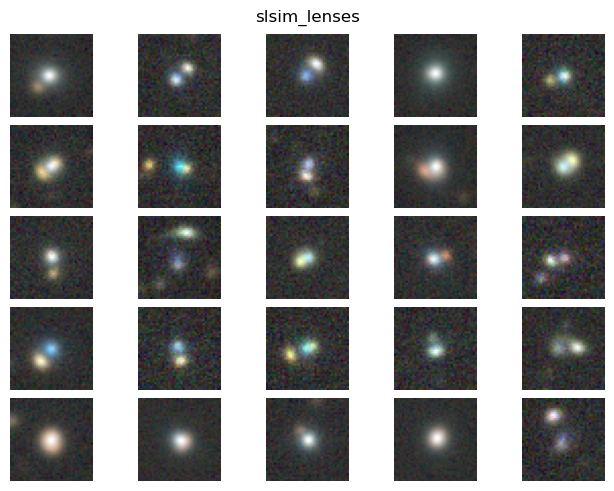

In [204]:
_, ax = plt.subplots(5, 5, constrained_layout=True)
for i in range(25):
    ax.flat[i].imshow(slsim_lenses[i][:,:,:3])
    ax.flat[i].axis("off")
plt.suptitle('slsim_lenses')
plt.show()

In [205]:
data = np.concatenate([hsc_lenses, slsim_lenses, hsc_nonlenses, slsim_nonlenses], axis=0)
labels = np.array(([1] * (len(hsc_lenses) + len(slsim_lenses))) + ([0] * (len(hsc_nonlenses) + len(slsim_nonlenses))), dtype=np.uint8)
print(data.shape)
print(labels.shape)

(400, 41, 41, 5)
(400,)


In [206]:
ds = tf_data.Dataset.from_tensor_slices((data, labels))
ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

In [207]:
# Calculate split sizes
total_size = len(labels)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
print(f'end={total_size}, train={train_size}, val={val_size}, test={test_size}')

# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}, Test size: {test_ds.cardinality()}")

end=400, train=280, val=80, test=40
Train size: 280, Val size: 80, Test size: 40


In [208]:
# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images)
#     return images

# # Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf_data.AUTOTUNE,
# )

In [209]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.batch(32).prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf_data.AUTOTUNE)

In [210]:
print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}, Test size: {test_ds.cardinality()}")

Train size: 9, Val size: 3, Test size: 2


In [200]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    num_bands = input_shape[2]

    # Entry block
    # x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, num_bands, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(num_bands, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, num_bands, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(41, 41, 5), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [201]:
epochs = 25

callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


ValueError: Input 0 of layer "functional_6" is incompatible with the layer: expected shape=(None, 41, 41, 5), found shape=(41, 41, 5)

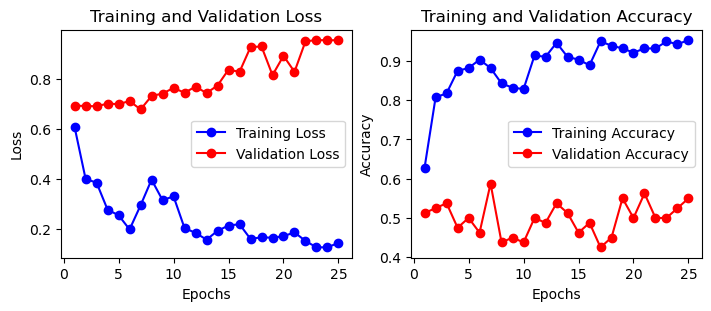

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training Loss')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training Accuracy')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.0873973369598389
Test accuracy: 0.4749999940395355


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


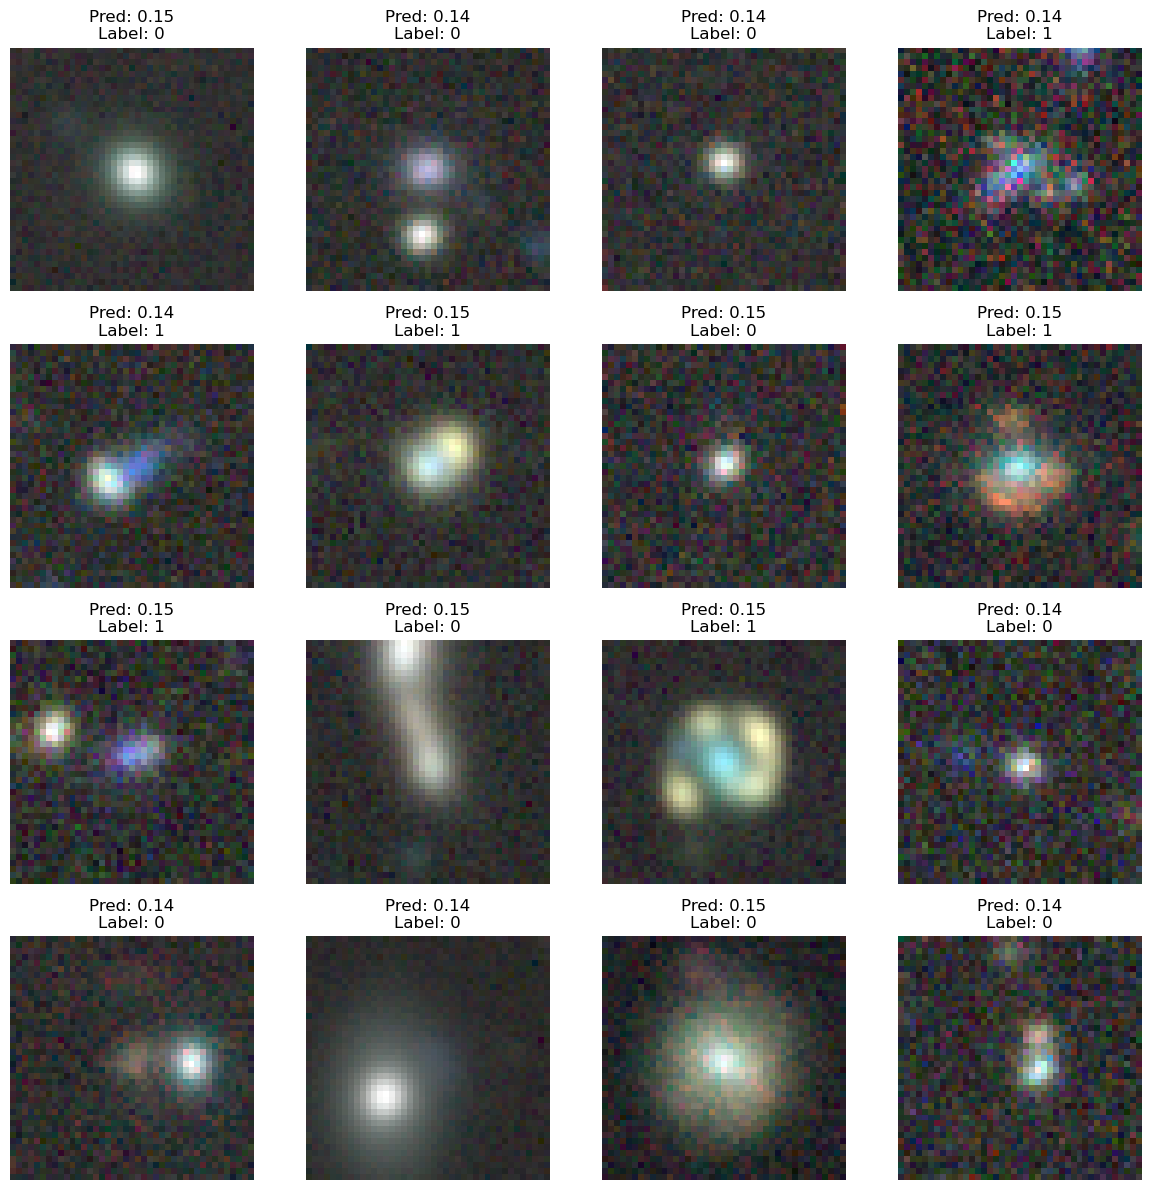

In [ ]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy()[:,:,:3])
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


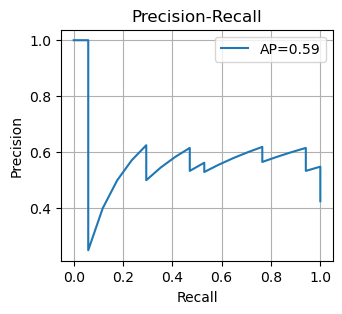

In [ ]:
# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()  # Use sigmoid to get probabilities
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.5, 3))
plt.plot(recall, precision, label=f'AP={ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


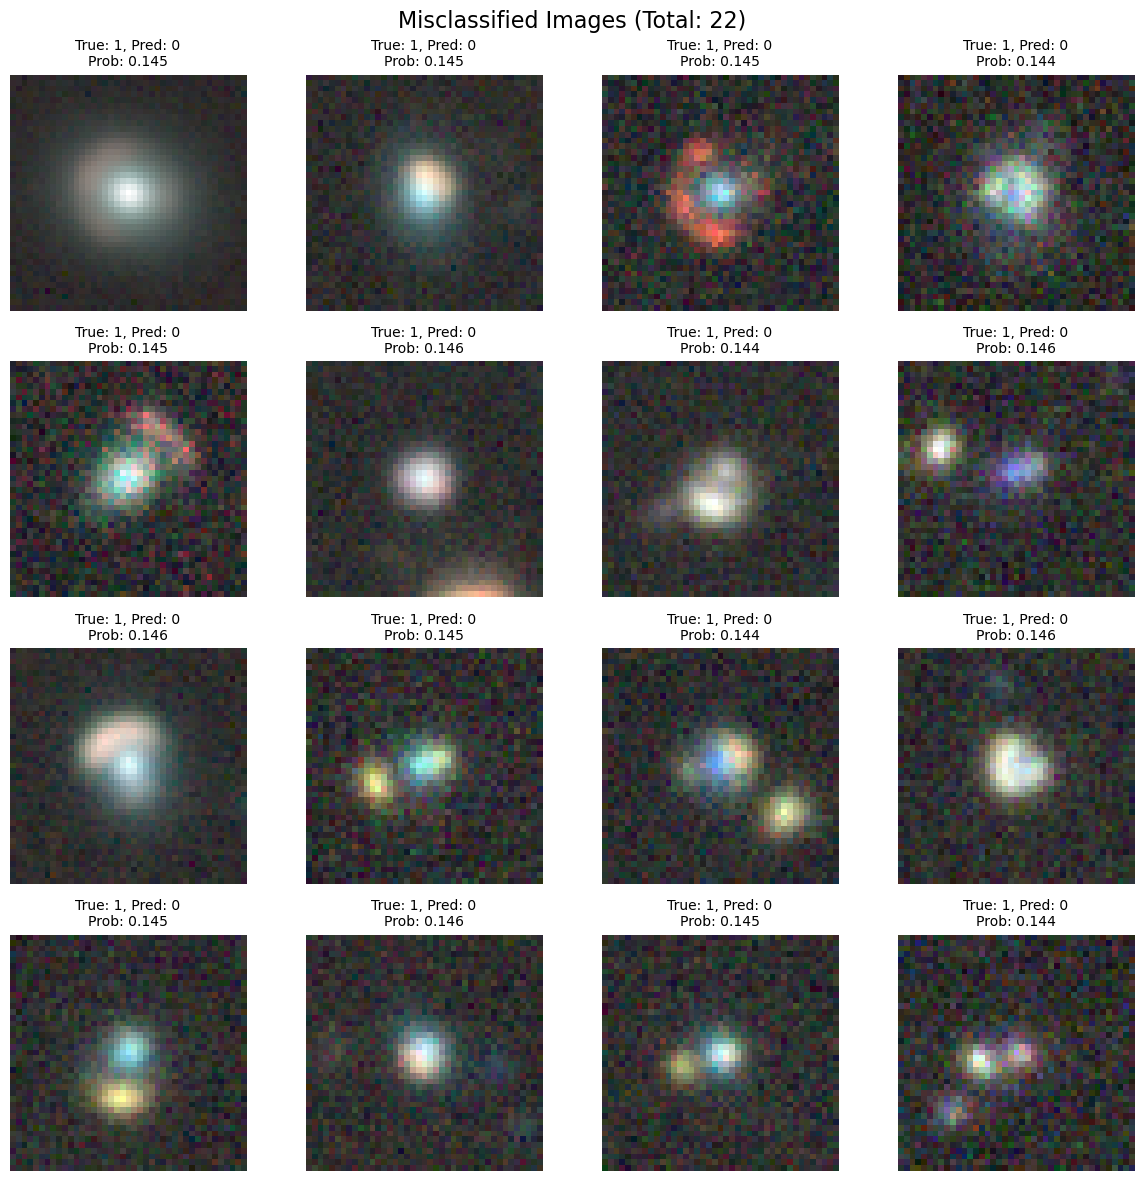

Total misclassified images: 22


In [ ]:
# Collect misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_probs = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    
    # Convert probabilities to binary predictions (threshold at 0.5)
    pred_labels = (probs > 0.5).astype(int)
    true_labels = labels_batch.numpy().flatten().astype(int)
    
    # Find misclassified samples
    misclassified_mask = pred_labels != true_labels
    
    if np.any(misclassified_mask):
        misclassified_images.extend(images_batch[misclassified_mask].numpy())
        misclassified_labels.extend(true_labels[misclassified_mask])
        misclassified_probs.extend(probs[misclassified_mask])

# Display misclassified images
num_to_show = min(16, len(misclassified_images))
if num_to_show > 0:
    plt.figure(figsize=(12, 12))
    for i in range(num_to_show):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(misclassified_images[i][:,:,:3])
        true_label = misclassified_labels[i]
        pred_prob = misclassified_probs[i]
        pred_label = 1 if pred_prob > 0.5 else 0
        plt.title(f"True: {true_label}, Pred: {pred_label}\nProb: {pred_prob:.3f}", fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Misclassified Images (Total: {len(misclassified_images)})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Total misclassified images: {len(misclassified_images)}")
else:
    print("No misclassified images found!")